# Model NLCT

The attempt here is to create a sythetic version of the NLCT (11-3.9um) using GFS model data. 

This is similar to the MODEL_FLC_V2. However, in that version we were subtracting the SST from the air temperature to find inversion regions of cold SST and warm air. This time, we are using the humidity to estimate the weighting function and create a guess at the brightness temperature difference. 

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

When collecting data, remember that we are using **Model_flc_v2_data**, it has its own collection program:

In [2]:
data_root = "/home/jturner/false_low_clouds_2023/Model/Model_flc_v2_data/"
region = "Georges_Bank"

In [3]:
time="06z"

date="20230921"

Import the GFS and SST data
* needs to use the old GFS grib files, the new netCDF files have already been processed to temperature difference

In [4]:
%%capture
gfs_file = data_root+"time_"+time+"/"+date+"/gfs.t"+time+".pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib", backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

In [5]:
sst_file = data_root+"time_"+time+"/"+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Filter the datasets to the region of interest

In [6]:
#---Custom
# min_lon = -74
# min_lat = 37
# max_lon = -64
# max_lat = 43

#---Custom (zoomed in)
# min_lon = -72
# min_lat = 39
# max_lon = -67
# max_lat = 43

#---Gulf Stream
min_lon = -77
min_lat = 33
max_lon = -50
max_lat = 45

In [7]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))

#--- GFS data latitude is reversed compared to the SST data, this flips it into position.
gfs_ds = gfs_ds.sel(latitude=slice(None, None, -1))

gfs_ds = gfs_ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

For atmospheric temperature, use from the level of most humidity

Identify the indices where the maximum humidity occurs for each height level

In [8]:
max_humidity_indices = gfs_ds['q'].argmax(dim='isobaricInhPa')

Use these indices to filter the temperature data

In [9]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = gfs_ds.t.values[0][0:begin,0:end]

#---For some bizarre reason, this initialization of T_maxq seems to be necessary
#---Another bizarre action is that this changes dims to a numpy array
T_maxq = np.zeros(dims.shape)
T_maxq = gfs_ds['t'].isel(isobaricInhPa=max_humidity_indices)
T_maxq = T_maxq[0:begin,0:end].values

Adding a rudimentary weighting function system:
* if more moist, 3.9 Tb estimate is minorly colder, 11 Tb majorly colder
* if more moist, more weight on atmospheric temperature
* if more dry, more weight on SST

*Replace this method with some actual values referencing the weighting function lookup table*

In [10]:
#--- Scaling the humidity values to between 0 and 1 (normalization)
q = gfs_ds['q'].isel(isobaricInhPa=max_humidity_indices).values
q = q[0:begin,0:end]
print('max q:', np.max(q), 'min q:', np.min(q))

#--- Using physical knowledge (my guess) to set q_max and q_min
q_max = 0.012
q_min = 0.005
q_n = (q - q_min) / (q_max - q_min)

max q: 0.02043839 min q: 0.0044799903


In [11]:
sst = sst_ds.sst[:,:].values

Estimating the band brightness temperatures:
* experimented with more weighting of the atmosphere, and less of surface, but this caused a less accurate image and less accurate brightness temperature range
* I am not getting as much positive BTD as I would expect, room for improvement here

In [12]:
b_07 = q_n*T_maxq + (1-q_n)*sst
b_14 = 2*q_n*T_maxq + (1-(2*q_n))*sst

In [13]:
btd = b_14-b_07

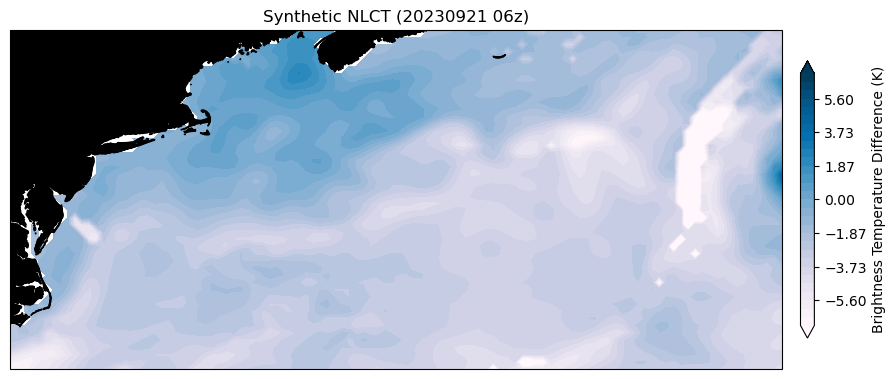

In [14]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PuBu
#levels = np.linspace(np.nanmin(btd), np.nanmax(btd), 31)
levels = np.linspace(-7, 7, 31)

c=ax.contourf(sst_ds.lon, sst_ds.lat, btd, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Synthetic NLCT ('+date+' '+ time+')')
clb.set_label('Brightness Temperature Difference (K)')

ax.add_feature(cfeature.LAND, zorder=100, color='black', edgecolor='k')
ax.coastlines(resolution='50m', color='black', linewidth=1)

In [15]:
np.save('model_btd_gulfstream_'+date+time+'.npy', btd)

Test the Model NLCT against some known cases:

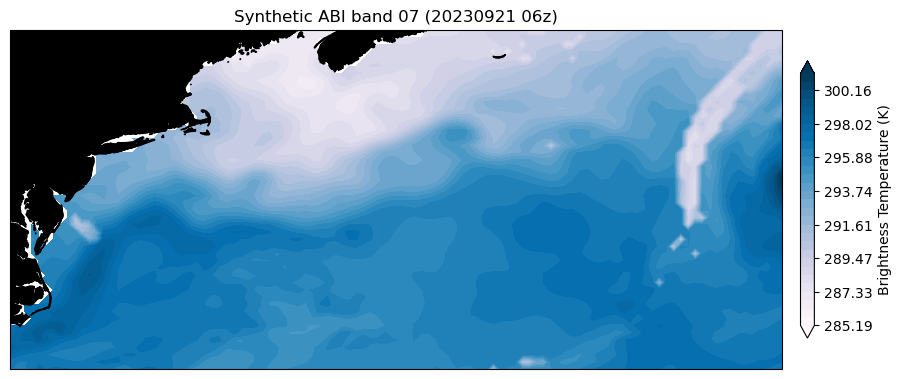

In [16]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PuBu
levels = np.linspace(np.nanmin(b_07), np.nanmax(b_07), 31)

c=ax.contourf(sst_ds.lon, sst_ds.lat, b_07, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Synthetic ABI band 07 ('+date+' '+ time+')')
clb.set_label('Brightness Temperature (K)')

ax.add_feature(cfeature.LAND, zorder=100, color='black', edgecolor='k')
ax.coastlines(resolution='50m', color='black', linewidth=1)